# 卷积神经网络对图片进行分类。kaggle

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import os,time
import numpy as np
import pandas as pd
import sklearn
import sys
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl,np,pd,sklearn,tf,keras:
    print(module.__name__,module.__version__)


2.0.0
sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)
matplotlib 3.1.3
numpy 1.18.1
pandas 1.0.1
sklearn 0.22.2
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [48]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):#通过在目录树中游走输出在目录中的文件名，向上或者向下。返回的是一个三元组(root,dirs,files)
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/10-monkey-species/monkey_labels.txt
/kaggle/input/10-monkey-species/training/training/n5/n5027.jpg
/kaggle/input/10-monkey-species/training/training/n5/n5161.jpg
/kaggle/input/10-monkey-species/training/training/n5/n5021.jpg
/kaggle/input/10-monkey-species/training/training/n5/n5154.jpg
/kaggle/input/10-monkey-species/training/training/n5/n5071.jpg
/kaggle/input/10-monkey-species/training/training/n5/n5145.jpg
/kaggle/input/10-monkey-species/training/training/n5/n5038.jpg
/kaggle/input/10-monkey-species/training/training/n5/n5020.jpg
/kaggle/input/10-monkey-species/training/training/n5/n5054.jpg
/kaggle/input/10-monkey-species/training/training/n5/n5019.jpg
/kaggle/input/10-monkey-species/training/training/n5/n5044.jpg
/kaggle/input/10-monkey-species/training/training/n5/n5159.jpg
/kaggle/input/10-monkey-species/training/training/n5/n5018.jpg
/kaggle/input/10-monkey-species/training/training/n5/n5110.jpg
/kaggle/input/10-monkey-species/training/training/n5/n5047.jpg
/kagg

In [49]:
train_dir = '/kaggle/input/10-monkey-species/training/training'
valid_dir = '/kaggle/input/10-monkey-species/validation/validation'
label_file = '/kaggle/input/10-monkey-species/monkey_labels.txt'
print(os.path.exists(train_dir))
print(os.path.exists(valid_dir))
print(os.path.exists(label_file))
print(os.listdir(train_dir))

True
True
True
['n5', 'n3', 'n6', 'n4', 'n2', 'n8', 'n0', 'n7', 'n9', 'n1']


In [50]:

lables = pd.read_csv(label_file,header=0)
print(lables)

   Label     Latin Name              Common Name                     \
0  n0         alouatta_palliata\t    mantled_howler                   
1  n1        erythrocebus_patas\t    patas_monkey                     
2  n2        cacajao_calvus\t        bald_uakari                      
3  n3        macaca_fuscata\t        japanese_macaque                 
4  n4       cebuella_pygmea\t        pygmy_marmoset                   
5  n5       cebus_capucinus\t        white_headed_capuchin            
6  n6       mico_argentatus\t        silvery_marmoset                 
7  n7      saimiri_sciureus\t        common_squirrel_monkey           
8  n8       aotus_nigriceps\t        black_headed_night_monkey        
9  n9       trachypithecus_johnii    nilgiri_langur                   

    Train Images    Validation Images  
0             131                  26  
1             139                  28  
2             137                  27  
3             152                  30  
4             131 

In [51]:
height = 128# 定义将图片缩放到同样大小图片大小
width = 128 
channels = 3# 彩色图片，3通道
batch_size = 64 # 生产的图片多少张为一组
num_classes = 10# 类别的个数
# ImageDataGenerator读取图片并作数据增强,用以生成一个batch的图像数据，支持实时数据提升。
# 训练时该函数会无限生成数据，直到达到规定的epoch次数为止。
# 1、初始化一个generator
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,# 将图片随机旋转角度，40指0-40之间随机选一个数
    width_shift_range= 0.2,# 对数据进行位移小于1代表最大比例，大于1代表最大像素值
    height_shift_range =0.2,
    shear_range=0.2,# 剪切强度
    zoom_range=0.2,# 缩放强度
    horizontal_flip= True,# 随机水平翻转
    fill_mode='nearest',# 如果填充像素，采用的方法
)
# 2、读取图片
# flow_from_directory(directory): 以文件夹路径为参数,生成经过数据提升/归一化后的数据,在一个无限循环中无限产生batch数据
# 子文件夹的名称作为labels
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(height,width),
                                                   batch_size=batch_size,
                                                   seed = 7,随机数种子
                                                   shuffle= True,
                                                   class_mode = 'categorical'
                                                    #lable的格式，categorical指one hot后的编码
                                                   )
valid_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
#  验证集一般不对图像处理，只要缩放值就可以
valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                   target_size=(height,width),
                                                   batch_size=batch_size,
                                                   seed = 7,
                                                   shuffle= False,
                                                   class_mode = 'categorical')
# class_mode: "categorical", "binary", "sparse"或None之一. 默认为"categorical. 
# 该参数决定了返回的标签数组的形式:
# "categorical"会返回2D的one-hot编码标签,
# "binary"返回1D的二值标签.
# "sparse"返回1D的整数标签,
# 如果为None则不返回任何标签, 生成器将仅仅生成batch数据, 
# 这种情况在使用model.predict_generator()和model.evaluate_generator()等函数时会用到.

train_num = train_generator.samples#查看数据数量
valid_num = valid_generator.samples
print(train_num,valid_num)

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.
1098 272


`https://keras-cn.readthedocs.io/en/latest/preprocessing/image/`

## 图片预处理
### 图片生成器ImageDataGenerator
用以生成一个batch的图像数据，支持实时数据提升。训练时该函数会无限生成数据，直到达到规定的epoch次数为止。

### 参数
featurewise_center：布尔值，使输入数据集去中心化（均值为0）, 按feature执行

samplewise_center：布尔值，使输入数据的每个样本均值为0

featurewise_std_normalization：布尔值，将输入除以数据集的标准差以完成标准化, 按feature执行

samplewise_std_normalization：布尔值，将输入的每个样本除以其自身的标准差

zca_whitening：布尔值，对输入数据施加ZCA白化

zca_epsilon: ZCA使用的eposilon，默认1e-6

rotation_range：整数，数据提升时图片随机转动的角度

width_shift_range：浮点数，图片宽度的某个比例，数据提升时图片水平偏移的幅度

height_shift_range：浮点数，图片高度的某个比例，数据提升时图片竖直偏移的幅度

shear_range：浮点数，剪切强度（逆时针方向的剪切变换角度）

zoom_range：浮点数或形如[lower,upper]的列表，随机缩放的幅度，若为浮点数，则相当于[lower,upper] = [1 - zoom_range, 1+zoom_range]

channel_shift_range：浮点数，随机通道偏移的幅度

fill_mode：；‘constant’，‘nearest’，‘reflect’或‘wrap’之一，当进行变换时超出边界的点将根据本参数给定的方法进行处理

cval：浮点数或整数，当fill_mode=constant时，指定要向超出边界的点填充的值

horizontal_flip：布尔值，进行随机水平翻转

vertical_flip：布尔值，进行随机竖直翻转

rescale: 重放缩因子,默认为None. 如果为None或0则不进行放缩,否则会将该数值乘到数据上(在应用其他变换之前)

preprocessing_function: 将被应用于每个输入的函数。该函数将在图片缩放和数据提升之后运行。该函数接受一个参数，为一张图片（秩为3的numpy array），并且输出一个具有相同shape的numpy array

data_format：字符串，“channel_first”或“channel_last”之一，代表图像的通道维的位置。该参数是Keras 1.x中的image_dim_ordering，“channel_last”对应原本的“tf”，“channel_first”对应原本的“th”。以128x128的RGB图像为例，“channel_first”应将数据组织为（3,128,128），而“channel_last”应将数据组织为（128,128,3）。该参数的默认值是~/.keras/keras.json中设置的值，若从未设置过，则为“channel_last”

`https://keras-cn.readthedocs.io/en/latest/preprocessing/image/`

## 方法

### fit(x, augment=False, rounds=1)

计算依赖于数据的变换所需要的统计信息(均值方差等),只有使用featurewise_center，featurewise_std_normalization或zca_whitening时需要此函数。

X：numpy array，样本数据，秩应为4.在黑白图像的情况下channel轴的值为1，在彩色图像情况下值为3

augment：布尔值，确定是否使用随即提升过的数据

round：若设augment=True，确定要在数据上进行多少轮数据提升，默认值为1

seed: 整数,随机数种子
    

### flow(self, X, y, batch_size=32, shuffle=True, seed=None, save_to_dir=None, save_prefix='', save_format='png')：

接收numpy数组和标签为参数,生成经过数据提升或标准化后的batch数据,并在一个无限循环中不断的返回batch数据

x：样本数据，秩应为4.在黑白图像的情况下channel轴的值为1，在彩色图像情况下值为3

y：标签

batch_size：整数，默认32

shuffle：布尔值，是否随机打乱数据，默认为True

save_to_dir：None或字符串，该参数能让你将提升后的图片保存起来，用以可视化

save_prefix：字符串，保存提升后图片时使用的前缀, 仅当设置了save_to_dir时生效

save_format："png"或"jpeg"之一，指定保存图片的数据格式,默认"jpeg"

yields:形如(x,y)的tuple,x是代表图像数据的numpy数组.y是代表标签的numpy数组.该迭代器无限循环.

seed: 整数,随机数种子


### flow_from_directory(directory): 

以文件夹路径为参数,生成经过数据提升/归一化后的数据,在一个无限循环中无限产生batch数据

directory: 目标文件夹路径,对于每一个类,该文件夹都要包含一个子文件夹.子文件夹中任何JPG、PNG、BNP、PPM的图片都会被生成器使用.详情请查看此脚本

target_size: 整数tuple,默认为(256, 256). 图像将被resize成该尺寸

color_mode: 颜色模式,为"grayscale","rgb"之一,默认为"rgb".代表这些图片是否会被转换为单通道或三通道的图片.

classes: 可选参数,为子文件夹的列表,如['dogs','cats']默认为None. 若未提供,则该类别列表将从directory下的子文件夹名称/结构自动推断。每一个子文件夹都会被认为是一个新的类。(类别的顺序将按照字母表顺序映射到标签值)。通过属性class_indices可获得文件夹名与类的序号的对应字典。

class_mode: "categorical", "binary", "sparse"或None之一. 默认为"categorical. 该参数决定了返回的标签数组的形式, "categorical"会返回2D的one-hot编码标签,"binary"返回1D的二值标签."sparse"返回1D的整数标签,如果为None则不返回任何标签, 生成器将仅仅生成batch数据, 这种情况在使用model.predict_generator()和model.evaluate_generator()等函数时会用到.

batch_size: batch数据的大小,默认32

shuffle: 是否打乱数据,默认为True

seed: 可选参数,打乱数据和进行变换时的随机数种子

save_to_dir: None或字符串，该参数能让你将提升后的图片保存起来，用以可视化

save_prefix：字符串，保存提升后图片时使用的前缀, 仅当设置了save_to_dir时生效

save_format："png"或"jpeg"之一，指定保存图片的数据格式,默认"jpeg"

flollow_links: 是否访问子文件夹中的软链接

In [52]:
for i in range(2):
    x,y = train_generator.next()
    print(x.shape,y.shape)
    print(y)

(64, 128, 128, 3) (64, 10)
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.

In [53]:
# kernel_size卷积窗口的长度
# pool_size池化窗口的长度
# 池化操作通常不重叠，不补0.pool_size=步长，用于减小图像尺寸，减少计算量
# filter输出的通道，即卷积核的数量
# padding='same'指填充padding使得输入输出大小相同，默认‘valid’指不填充
# strides=(1, 1)卷积时在每一维度上的步长
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32,kernel_size=3,padding='same',
                       activation='selu',input_shape=[width,height,channels]),
    keras.layers.Conv2D(filters=32,kernel_size=3,padding='same',
                       activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),#MaxPool，Avgpool
    
    keras.layers.Conv2D(filters=64,kernel_size=3,padding='same',
                       activation='selu'),
    keras.layers.Conv2D(filters=64,kernel_size=3,padding='same',
                       activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    
    keras.layers.Conv2D(filters=128,kernel_size=3,padding='same',
                       activation='selu'),
    keras.layers.Conv2D(filters=128,kernel_size=3,padding='same',
                       activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(128,activation='selu'),
    keras.layers.Dense(num_classes,activation='softmax')
])

model.compile(loss ='categorical_crossentropy',
             optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 32, 32, 128)      

In [54]:
epochs = 300
# 数据由generator生成，所以用fit_generator
history = model.fit_generator(train_generator,
                             steps_per_epoch=train_num//batch_size,
                              epochs= epochs,
                          validation_data = valid_generator,
                              validation_steps = valid_num//batch_size
                             )

Train for 17 steps, validate for 4 steps
Epoch 1/3
17/17 [==============================] - 39s 2s/step - loss: 16.3701 - accuracy: 0.1267 - val_loss: 3.7044 - val_accuracy: 0.2734
Epoch 2/3
17/17 [==============================] - 39s 2s/step - loss: 2.8007 - accuracy: 0.2456 - val_loss: 2.0732 - val_accuracy: 0.2891
Epoch 3/3
17/17 [==============================] - 38s 2s/step - loss: 1.9505 - accuracy: 0.3462 - val_loss: 1.7796 - val_accuracy: 0.4297


In [55]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


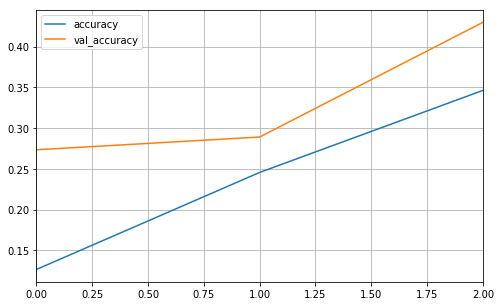

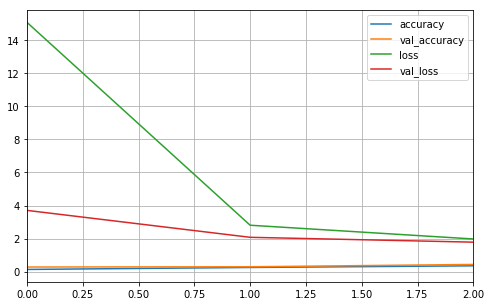

In [63]:
data={}
def plot_learning_curves(history,label, epochs, min_value, max_value):
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_'+label]
    pd.DataFrame(data).plot(figsize = (8,5))
    plt.grid(True)
#     plt.axis([0,epochs],[min_value,max_value])
    
plot_learning_curves(history,'accuracy',epochs,0,1)
plot_learning_curves(history,'loss',epochs,1,2.5)